# Contents

### Tune Ridge model for all numerical and categorical Ames features 

[Ridge](#Ridge)

<!-- [Evaluate model on train and test data](#Evaluate-model-on-train-and-test-data) -->

[Visualize train and test comparison](#Visualize-train-and-test-comparison)

[Visualize coefficients for varying alpha](#Visualize-coefficients-for-varying-alpha)

[Model tuning](#Model-tuning)

[Ridge with sfs](#Ridge-with-sfs)
- [sfs selected features](#sfs-selected-features)

[Summary](#Summary)

[Resources](#Resources)

[Extra](#Extra)

In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import Ridge

# Summary of previous data cleaning:

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'

**ames_clean.pkl** include these changes.

In [4]:
# Import raw data, if needed for comparison.
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


In [5]:
# Import cleaned data: ames_clean.pkl
ames = pd.read_pickle('ames_clean.pkl')

## Define datatypes

### Numerical features

In [8]:
ames.select_dtypes(include=['float64', 'int64']).head(2)

,GrLivArea,SalePrice,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,126000,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,139500,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [9]:
ames.select_dtypes(include=['float64', 'int64']).columns

Index(['GrLivArea', 'SalePrice', 'LotFrontage', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

**Note:** These are the correct, 32 numerical features

In [11]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_features_list.remove('SalePrice')
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


### Categorical features

In [13]:
print(f'number of categorical features: { len(ames.select_dtypes(include=["object"]).columns) }')

number of categorical features: 48


In [14]:
ames.select_dtypes(include=["object"]).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [15]:
categorical_features = ames.select_dtypes(include=["object"])
categorical_features.head(2)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,30,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,120,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,TA,TA,Y,None,None,None,2,2009,WD,Normal


In [16]:
categorical_features_list = categorical_features.columns.tolist()

In [17]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [18]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [19]:
# define features
X = ames[numerical_features_list].join(ames[categorical_features_list])
X.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,TA,TA,Y,None,None,None,2,2009,WD,Normal


In [20]:
# define target
y = ames['SalePrice']

# Ridge

[Contents](#Contents)

evaluate base model on full dataset and train-test split data to look for overfitting

In [22]:
# create storage for tuning results
tuning_results = {}

<!-- ## Evaluate model on train and test data

[Contents](#Contents) -->

In [24]:
# numeric transformer for scaling
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# categorical transformer for encoding
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore')) 
])

# define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features_list),
        ('cat', cat_transformer, categorical_features_list)
    ])

# define multiple model pipeline with preprocessor and regressor
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
            ('regressor', Ridge(max_iter=20000))]
)

In [25]:
# fit model on all data for baseline
pipeline.fit(X, y)

# evaluate base model performance
scores = cross_val_score(pipeline, X, y)
mean_score_base_model = scores.mean()
print(f'cv scores:', scores)
print(f'mean-cv base model score:', round(mean_score_base_model, 4))

# refit pipeline on train-test data to look for overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
pipeline.fit(X_train, y_train)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
diff = train_score - test_score

print(f'base model train score:', round(train_score, 4))
print(f'base model test score:', round(test_score, 4))
print(f'base model train-test gap:', round(diff, 4))

tuning_results['Model _0'] = {
    'mean-cv on X and y': round(mean_score_base_model, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4),
    'scenario': 'base model'
}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

cv scores: [0.87086895 0.92532961 0.92804709 0.9309013  0.92859821]
mean-cv base model score: 0.9167
base model train score: 0.9418
base model test score: 0.9248
base model train-test gap: 0.017


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Visualize train and test comparison

[Contents](#Contents)

In [27]:
intercepts = []
coefs = []
scores = []
alphaRange = np.linspace(0.1,65000,20)

# fit preprocessor and transform data for ridge visualization
preprocessor_fitted = pipeline.named_steps['preprocessor'].fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)

# for later
X_test_transformed = preprocessor_fitted.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [28]:
# intercepts = []
# coefs = []
# scores = []
# alphaRange = np.linspace(0.1,65000,20)

# # fit preprocessor and transform data for ridge visualization
# preprocessor_fitted = pipelines['Ridge'].named_steps['preprocessor'].fit(X_train)
# X_train_transformed = preprocessor_fitted.transform(X_train)

# # for later
# X_test_transformed = preprocessor_fitted.transform(X_test)

In [29]:
X_train_transformed

<2064x304 sparse matrix of type '<class 'numpy.float64'>'
	with 149022 stored elements in Compressed Sparse Row format>

In [30]:
ridge_train_R2 = []
ridge_test_R2  = []
alphaRange= np.linspace(0.1,65000,20)
for alpha in alphaRange:
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train_transformed, y_train)   
    ridge_train_R2.append(ridge.score(X_train_transformed, y_train))
    ridge_test_R2.append(ridge.score(X_test_transformed, y_test))

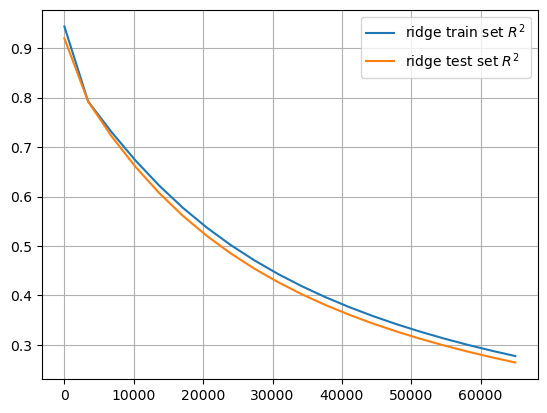

In [31]:
plt.plot(alphaRange, ridge_train_R2, label=r'ridge train set $R^2$')
plt.plot(alphaRange, ridge_test_R2, label=r'ridge test set $R^2$')
plt.legend(loc='upper right')
plt.grid()

#### zoom in on region where train and test scores converge

In [33]:
ridge_scores_train = []
ridge_scores_test  = []

alphas = np.linspace(0, 6000, 100)

for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_train_transformed, y_train)
    ridge_scores_train.append(ridge.score(X_train_transformed, y_train))
    ridge_scores_test.append(ridge.score(X_test_transformed, y_test))

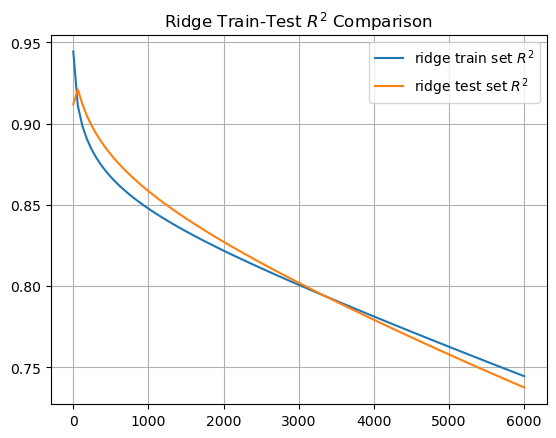

In [34]:
plt.plot(alphas, ridge_scores_train, label=r'ridge train set $R^2$')
plt.plot(alphas, ridge_scores_test, label=r'ridge test set $R^2$')
plt.legend(loc='upper right')
plt.title(r'Ridge Train-Test $R^2$ Comparison')
plt.grid()

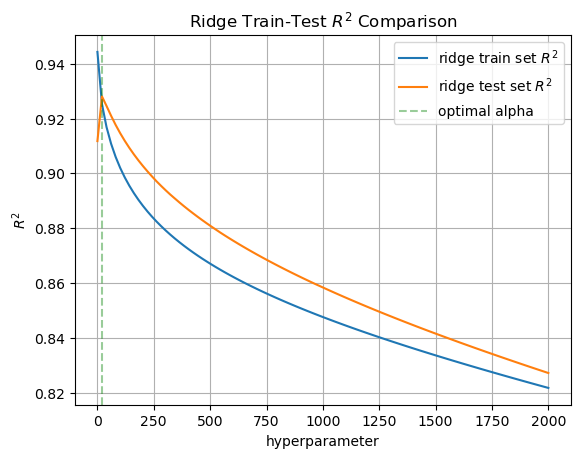

In [35]:
ridge_scores_train = []
ridge_scores_test  = []

# restrict alpha range to zoom in on first point of convergence
alphas = np.linspace(0, 2000, 100)

# get train and test scores for this range
for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_train_transformed, y_train)
    ridge_scores_train.append(ridge.score(X_train_transformed, y_train))
    ridge_scores_test.append(ridge.score(X_test_transformed, y_test))

# plot train-test scores for varying alpha
plt.plot(alphas, ridge_scores_train, label=r'ridge train set $R^2$')
plt.plot(alphas, ridge_scores_test, label=r'ridge test set $R^2$')
plt.legend(loc='upper right')
plt.title(r'Ridge Train-Test $R^2$ Comparison')
plt.grid()

# Convert lists to numpy arrays for element-wise subtraction
ridge_scores_train_array = np.array(ridge_scores_train)
ridge_scores_test_array = np.array(ridge_scores_test)
alphas_array = np.array(alphas)

# Find where train and test scores are closest
score_diff = np.abs(ridge_scores_train_array - ridge_scores_test_array)
optimal_idx = np.argmin(score_diff)
optimal_alpha = alphas_array[optimal_idx]

# plot line for optimal_alpha
plt.axvline(optimal_alpha, linestyle='--', color='g', label='optimal alpha', alpha=0.4)
plt.legend(loc='upper right')
plt.xlabel(r'hyperparameter')
plt.ylabel(r'$R^2$');

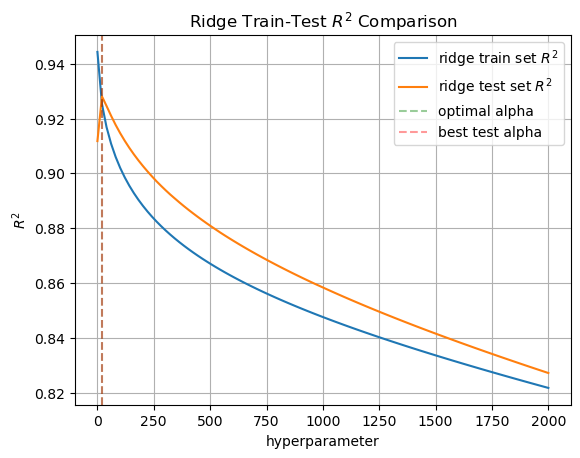

In [36]:
ridge_scores_train = []
ridge_scores_test  = []

# restrict alpha range to zoom in on first point of convergence
alphas = np.linspace(0, 2000, 100)

# get train and test scores for this range
for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_train_transformed, y_train)
    ridge_scores_train.append(ridge.score(X_train_transformed, y_train))
    ridge_scores_test.append(ridge.score(X_test_transformed, y_test))

# plot train-test scores for varying alpha
plt.plot(alphas, ridge_scores_train, label=r'ridge train set $R^2$')
plt.plot(alphas, ridge_scores_test, label=r'ridge test set $R^2$')
plt.legend(loc='upper right')
plt.title(r'Ridge Train-Test $R^2$ Comparison')
plt.grid()

# Convert lists to numpy arrays for element-wise subtraction
ridge_scores_train_array = np.array(ridge_scores_train)
ridge_scores_test_array = np.array(ridge_scores_test)
alphas_array = np.array(alphas)

# Find where train and test scores are closest
score_diff = np.abs(ridge_scores_train_array - ridge_scores_test_array)
optimal_idx = np.argmin(score_diff)
optimal_alpha = alphas_array[optimal_idx]

# find where test score is highest
best_test_score = np.max(ridge_scores_test_array)
best_test_idx = np.argmax(ridge_scores_test_array)
best_test_alpha = alphas_array[best_test_idx]

# plot line for optimal_alpha
plt.axvline(optimal_alpha, linestyle='--', color='g', label='optimal alpha', alpha=0.4)
plt.axvline(best_test_alpha, linestyle='--', color='r', label='best test alpha', alpha=0.4)
plt.legend(loc='upper right')
plt.xlabel(r'hyperparameter')
plt.ylabel(r'$R^2$');

<!-- # Perform cross validation
on all the data for model comparison

[Contents](#Contents) -->

# Visualize coefficients for varying alpha

[Contents](#Contents)

In [39]:
intercepts = []
coefs = []
scores = []

alphaRange = np.linspace(0.1,6500,20)

# fit preprocessor and transform data for ridge visualization
preprocessor_fitted = pipeline.named_steps['preprocessor'].fit(X)
X_transformed = preprocessor_fitted.transform(X)

In [40]:
X_transformed

<2580x309 sparse matrix of type '<class 'numpy.float64'>'
	with 186313 stored elements in Compressed Sparse Row format>

In [41]:
# convert sparse matric to dense numpy array
X_dense_array = X_transformed.toarray()
X_dense_array

array([[-1.28959751, -0.02047921, -0.27446818, ...,  0.        ,
         1.        ,  0.        ],
       [-0.89455537, -1.27733684, -0.72429425, ...,  0.        ,
         1.        ,  0.        ],
       [-0.9928042 , -0.40720463, -0.49968889, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.05609313,  0.65629028, -0.47384389, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.72859705, -0.02047921, -0.15927332, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.86982974,  0.55960893, -0.06967732, ...,  0.        ,
         1.        ,  0.        ]])

In [42]:
feature_names = preprocessor_fitted.get_feature_names_out()
X_df = pd.DataFrame(X_dense_array, columns=feature_names)
X_df.head(2)

,num__GrLivArea,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,...,cat__SaleType_ConLw,cat__SaleType_New,cat__SaleType_Oth,cat__SaleType_VWD,cat__SaleType_WD,cat__SaleCondition_AdjLand,cat__SaleCondition_Alloca,cat__SaleCondition_Family,cat__SaleCondition_Normal,cat__SaleCondition_Partial
0,-1.289598,-0.020479,-0.274468,-1.053847,-1.647539,-0.562750,-0.480748,-0.305221,0.185710,-0.431804,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.894555,-1.277337,-0.724294,0.460593,0.012109,0.286195,0.250896,1.948743,-1.023592,0.029483,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [43]:
ridge = Ridge()
for alpha in alphaRange:
    ridge.set_params(alpha=alpha)    
    ridge.fit(X_dense_array, y)
    intercepts.append(ridge.intercept_)
    coefs.append(ridge.coef_)
    scores.append(ridge.score(X_dense_array, y))

In [44]:
ridge_coefs_df = pd.DataFrame(np.array(coefs), columns=X_df.columns)
ridge_coefs_df

,num__GrLivArea,num__LotFrontage,num__LotArea,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,...,cat__SaleType_ConLw,cat__SaleType_New,cat__SaleType_Oth,cat__SaleType_VWD,cat__SaleType_WD,cat__SaleCondition_AdjLand,cat__SaleCondition_Alloca,cat__SaleCondition_Family,cat__SaleCondition_Normal,cat__SaleCondition_Partial
0,15461.808542,68.640266,4505.067366,11619.554793,1315.076344,3434.763325,24820.679619,9283.177261,15654.308239,-8625.827709,...,4850.559457,-6103.708204,-9439.844870,-5625.586461,1588.059652,-8111.706427,16604.188862,-13454.518948,8124.517705,27920.898133
1,13073.191912,2290.185468,2907.055475,5748.431612,5647.544512,7200.471890,7887.739040,1932.150094,886.886371,9763.687940,...,-41.812828,3143.951514,-144.374853,-69.431355,-1572.030555,-97.073650,19.148536,-1309.692900,248.787207,3400.221235
2,11628.073213,2558.901445,2880.899088,4531.711747,5708.000469,6956.075665,7455.646982,1539.615063,984.278484,9273.893453,...,-25.020436,2170.942657,-78.071085,-39.390120,-1268.108607,-58.349052,-0.851065,-701.700807,-311.107240,2301.873443
3,10695.431802,2655.775531,2864.010422,4031.315369,5576.147240,6659.004519,7069.748493,1301.706239,1011.373111,8812.054012,...,-18.807047,1717.286692,-55.970736,-27.681140,-1064.148833,-41.764361,-5.379194,-480.335558,-429.153933,1806.082835
4,10012.303311,2697.275094,2838.474171,3779.428198,5414.402852,6389.374830,6739.369727,1137.949481,1023.228599,8419.566895,...,-16.080004,1445.035426,-44.921761,-21.362531,-921.567415,-32.545758,-6.859434,-365.472302,-455.230533,1512.547015
5,9476.505906,2713.433104,2805.975866,3637.053606,5255.245662,6150.505546,6453.924260,1016.945584,1029.032622,8083.696802,...,-14.754197,1260.547753,-38.253274,-17.394378,-816.458868,-26.673948,-7.344080,-295.073685,-453.833990,1315.160155
6,9037.441543,2715.520096,2769.057650,3549.297785,5106.486483,5938.013302,6203.748491,923.246775,1031.507936,7791.462351,...,-14.071660,1126.033104,-33.757858,-14.668028,-735.665198,-22.607269,-7.429372,-247.476768,-443.122852,1171.967478
7,8666.417036,2708.825760,2729.569607,3490.850621,4969.407178,5747.342968,5981.563629,848.176541,1031.812758,7533.205517,...,-13.709393,1022.969899,-30.497959,-12.679163,-671.514289,-19.626080,-7.338639,-213.133384,-429.375645,1062.655539
8,8345.658064,2696.244081,2688.744317,3448.844638,4843.370870,5574.748739,5781.998211,786.430846,1030.566739,7301.954021,...,-13.514287,941.105723,-28.008643,-11.164539,-619.254675,-17.348659,-7.168408,-187.177066,-415.011060,976.071515
9,8063.437369,2679.540086,2647.392321,3416.290517,4727.229804,5417.274709,5601.043449,734.567917,1028.152120,7092.612881,...,-13.408229,874.266065,-26.033337,-9.973040,-575.790476,-15.553445,-6.964215,-166.865825,-401.000130,905.537958


/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_1658/1933166332.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


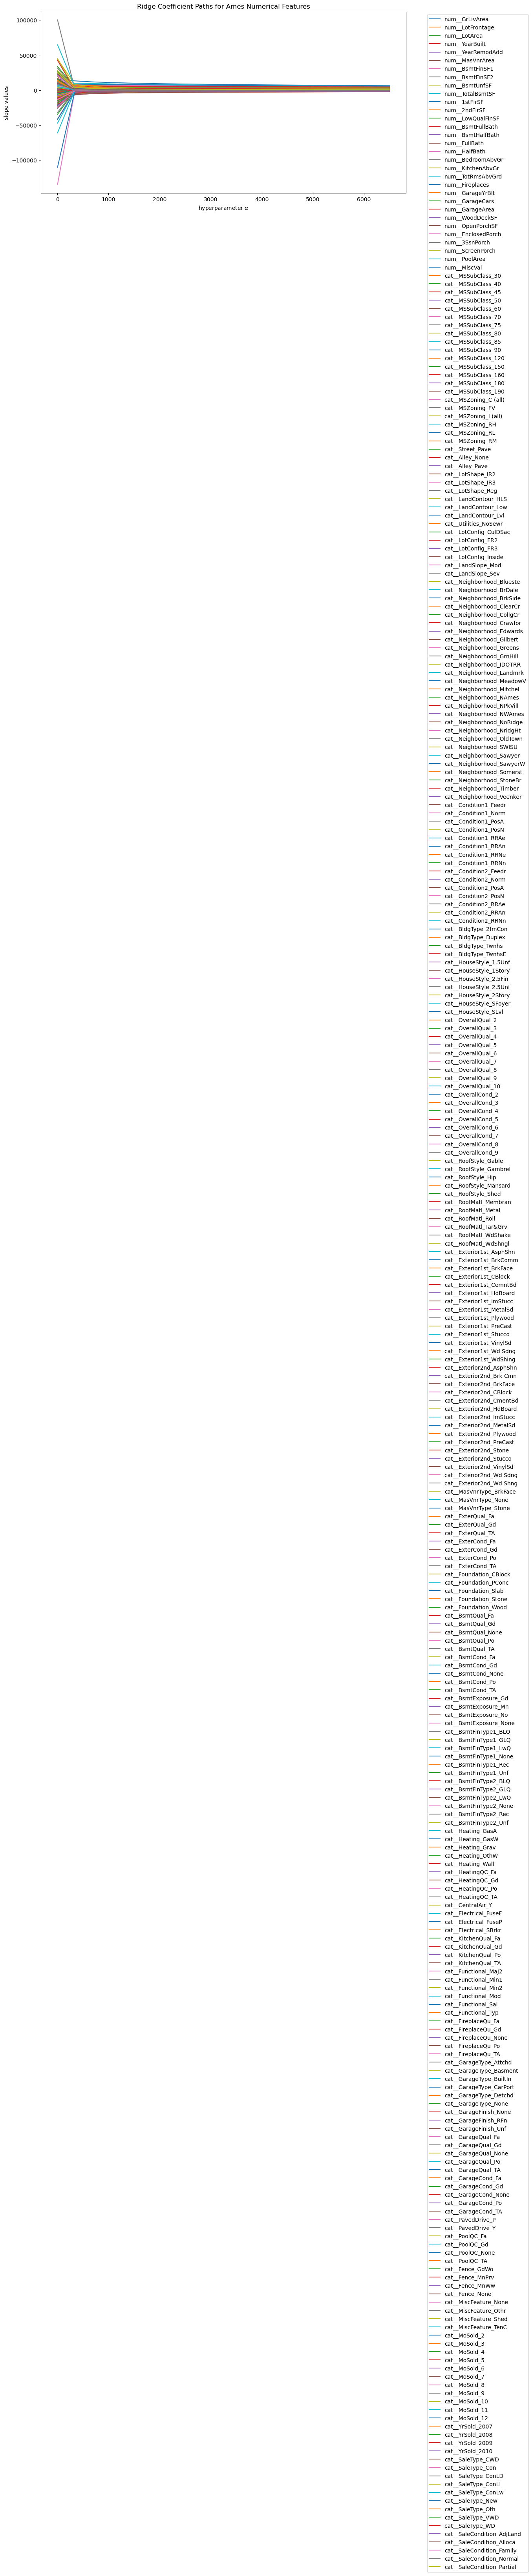

In [45]:
plt.figure(figsize=(12, 6)) 

# Visualize coefficients for varying alphas
for name in ridge_coefs_df.columns:
    plt.plot(alphaRange, ridge_coefs_df[name], label=name)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r'hyperparameter $\alpha$')
plt.ylabel(r'slope values')
plt.title('Ridge Coefficient Paths for Ames Numerical Features')

# Adjust layout to prevent overlapping
plt.tight_layout()     

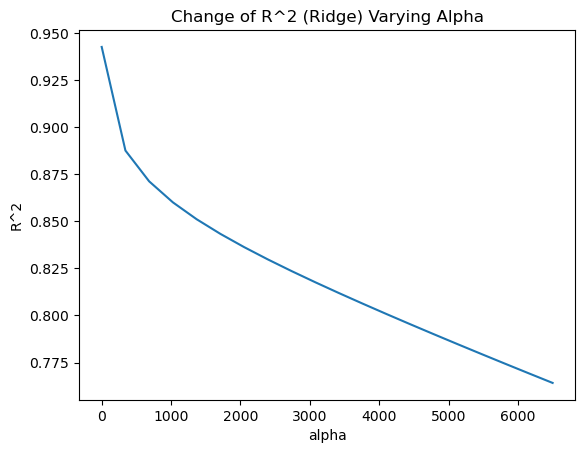

In [46]:
plt.plot(alphaRange, scores)
plt.title('Change of R^2 (Ridge) Varying Alpha')
plt.xlabel(r'alpha')
plt.ylabel(r'R^2')
plt.grid;

# Model tuning

[Contents](#Contents)

In [48]:
# run GridSearchCV on ridge to obtain optimal alpha

# define range of alpha values for ridge
alpha = list(range(1, 21, 1))  
 
# initialize Grid Search for Ridge
ridge_grid_1 = GridSearchCV(estimator=pipeline,
                          param_grid={'regressor__alpha': alpha},
                          verbose=1)
 
# fit on all data for overall score
ridge_grid_1.fit(X, y)
 
# Extract the best alpha and best score
ridge_best_alpha_1 = ridge_grid_1.best_params_['regressor__alpha']
ridge_best_score_1 = ridge_grid_1.best_score_
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters:', ridge_best_alpha_1)
print(f'mean cv score on full dataset:', round(ridge_best_score_1,4))
print('-----------')

# check for overfitting on train-test data
ridge_grid_1.fit(X_train, y_train)
train_score = ridge_grid_1.score(X_train, y_train)
test_score = ridge_grid_1.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _1'] = {
    'mean-cv on X and y': round(ridge_best_score_1,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4) ,
    'scenario': f'alpha = {ridge_best_alpha_1}'
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

MODEL _1:
Evaluate model on full dataset:
model parameters: 3
mean cv score on full dataset: 0.9174
-----------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 11, 24, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 22, 29, 43] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skle

Check for overfitting on train-test data:
train score: 0.9358
test score: 0.9286
train-test gap: 0.0072


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 11, 24, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 22, 29, 43] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/

# Ridge with sfs

[Contents](#Contents)

In [50]:
# numeric pipeline with sequential feature selection
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(
        estimator =  Ridge(max_iter=20000),
        n_features_to_select = 'auto',
        direction = 'forward',
        cv = 5,
        scoring = 'r2'
    ))
])

# categorical feature pipeline
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features_list),
        ('cat', cat_transformer, categorical_features_list)
    ])

# define multiple model pipeline with preprocessor and regressor on default params
pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), 
            ('regressor', Ridge(max_iter=20000))]
)

# fit on all data and score
pipeline.fit(X, y)
scores = cross_val_score(pipeline, X, y)
mean_cv = scores.mean()
# ridge_best_alpha_1 = ridge_grid_1.best_params_['regressor__alpha']
# ridge_best_score_1 = ridge_grid_1.best_score_
print('MODEL _2:')
print('Evaluate model on full dataset:')
print(f'cv scores:', scores)
print(f'mean cv score on full dataset:', round(mean_cv,4))
print('-----------')

# check for overfitting on train-test data
pipeline.fit(X_train, y_train)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _2'] = {
    'mean-cv on X and y': round(mean_cv,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4),
    'scenario': f'sfs-reduced'
}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

MODEL _2:
Evaluate model on full dataset:
cv scores: [0.87041959 0.92560545 0.92768055 0.92946209 0.92713681]
mean cv score on full dataset: 0.9161
-----------
Check for overfitting on train-test data:
train score: 0.9402
test score: 0.9208
train-test gap: 0.0194


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# sfs selected features
[Contents](#Contents)

In [75]:
sfs = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['sfs']
# Get the number of selected features
n_selected = sfs.n_features_to_select_
print(f"Number of features selected: {n_selected}")

Number of features selected: 15


In [77]:
# Get selected feature names
sfs = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['sfs']
selected_features = [numerical_features_list[i] for i in sfs.get_support(indices=True)]

print(f"The 15 selected features are:")
print(selected_features)

The 15 selected features are:
['GrLivArea', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF']


In [52]:
# run GridSearchCV on sfs optimized ridge to obtain optimal alpha

# Time the procedure
import time

start_time = time.time()  # Record the start time

# define range of alpha values for ridge
alpha = list(range(1, 11, 1))  
 
# initialize Grid Search for ridge
ridge_grid_3 = GridSearchCV(estimator=pipeline,
                          param_grid={'regressor__alpha': alpha},
                          verbose=1) #Prints out progress
 
# fit on all data and score
ridge_grid_3.fit(X, y)
best_model_3 = ridge_grid_3.best_estimator_

# evaluate
model_params_3 = ridge_grid_3.best_params_
full_cv = round(ridge_grid_3.best_score_, 4)
print('MODEL _3:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params_3)
print(f'mean cv score on full dataset:', round(full_cv,4))
print('-----------')

# check for overfitting on train-test data
ridge_grid_3.fit(X_train, y_train)
best_train_model = ridge_grid_3.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _3'] = {
    'mean-cv on X and y': round(full_cv,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4),
    'scenario': f'sfs-reduced, alpha = {model_params_3["regressor__alpha"]}'
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

MODEL _3:
Evaluate model on full dataset:
model parameters: {'regressor__alpha': 3}
mean cv score on full dataset: 0.9168
-----------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 11, 24, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skl

Check for overfitting on train-test data:
train score: 0.9345
test score: 0.925
train-test gap: 0.0095


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [54]:
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap,scenario
Model _1,0.9174,0.9358,0.9286,0.0072,alpha = 3
Model _3,0.9168,0.9345,0.925,0.0095,"sfs-reduced, alpha = 3"
Model _0,0.9167,0.9418,0.9248,0.017,base model
Model _2,0.9161,0.9402,0.9208,0.0194,sfs-reduced


<!-- # SHAP Analysis
evaluate on best model *say, best_model_3* to see if it works -->

In [90]:
# import shap
# explainer = shap.LinearExplainer(best_model_3, X_train)
# shap_values = explainer.shap_values(X_test)

# Summary

[Contents](#Contents)

In [66]:
tuning_results_df

,mean-cv on X and y,train score,test score,train-test gap,scenario
Model _0,0.9167,0.9418,0.9248,0.017,base model
Model _1,0.9174,0.9358,0.9286,0.0072,alpha = 3
Model _2,0.9161,0.9402,0.9208,0.0194,sfs-reduced
Model _3,0.9168,0.9345,0.925,0.0095,"sfs-reduced, alpha = 3"


In [58]:
# save data for model comparisons
ridge_models = tuning_results_df.copy()
ridge_models['algorithm'] = 'Ridge'
ridge_models

,mean-cv on X and y,train score,test score,train-test gap,scenario,algorithm
Model _0,0.9167,0.9418,0.9248,0.017,base model,Ridge
Model _1,0.9174,0.9358,0.9286,0.0072,alpha = 3,Ridge
Model _2,0.9161,0.9402,0.9208,0.0194,sfs-reduced,Ridge
Model _3,0.9168,0.9345,0.925,0.0095,"sfs-reduced, alpha = 3",Ridge


In [60]:
ridge_models.index.name = 'model'
ridge_models = ridge_models.reset_index()
ridge_models

,model,mean-cv on X and y,train score,test score,train-test gap,scenario,algorithm
0,Model _0,0.9167,0.9418,0.9248,0.017,base model,Ridge
1,Model _1,0.9174,0.9358,0.9286,0.0072,alpha = 3,Ridge
2,Model _2,0.9161,0.9402,0.9208,0.0194,sfs-reduced,Ridge
3,Model _3,0.9168,0.9345,0.925,0.0095,"sfs-reduced, alpha = 3",Ridge


In [62]:
ridge_models.to_csv('ridge_models.csv')

# example cv-fold analysis:

In [104]:
cv_scores = cross_val_score(best_model_3, X, y)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

In [106]:
cv_scores

array([0.87056609, 0.92475999, 0.93139183, 0.92879547, 0.92873372])

In [109]:
import numpy as np
import scipy.stats as stats
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

# 1. Basic Statistics
print("1. BASIC STATISTICS:")
print(f"Mean CV Score: {np.mean(cv_scores):.6f}")
print(f"Standard Deviation: {np.std(cv_scores, ddof=1):.6f}")
print(f"Standard Error: {stats.sem(cv_scores):.6f}")
print(f"Coefficient of Variation: {(np.std(cv_scores, ddof=1)/np.mean(cv_scores)*100):.2f}%")
print()

1. BASIC STATISTICS:
Mean CV Score: 0.916849
Standard Deviation: 0.025981
Standard Error: 0.011619
Coefficient of Variation: 2.83%



In [113]:
# 2. Confidence Intervals
print("2. CONFIDENCE INTERVALS:")
# 95% CI using t-distribution (appropriate for small sample)
confidence_level = 0.95
alpha = 1 - confidence_level
df = len(cv_scores) - 1
t_critical = stats.t.ppf(1 - alpha/2, df)
margin_error = t_critical * stats.sem(cv_scores)

ci_lower = np.mean(cv_scores) - margin_error
ci_upper = np.mean(cv_scores) + margin_error
print(f"95% Confidence Interval: [{ci_lower:.6f}, {ci_upper:.6f}]")

# Bootstrap CI for comparison
def bootstrap_mean(data):
    return np.mean(data)

bootstrap_ci = bootstrap((cv_scores,), bootstrap_mean, n_resamples=10000, 
                        confidence_level=0.95, random_state=42)
print(f"Bootstrap 95% CI: [{bootstrap_ci.confidence_interval.low:.6f}, {bootstrap_ci.confidence_interval.high:.6f}]")
print()

2. CONFIDENCE INTERVALS:
95% Confidence Interval: [0.884589, 0.949110]
Bootstrap 95% CI: [0.882200, 0.929027]



In [115]:
# 3. Distribution Analysis
print("3. DISTRIBUTION ANALYSIS:")
print(f"Minimum Score (Worst-case): {np.min(cv_scores):.6f}")
print(f"Maximum Score (Best-case): {np.max(cv_scores):.6f}")
print(f"Range: {np.max(cv_scores) - np.min(cv_scores):.6f}")
print(f"Median: {np.median(cv_scores):.6f}")

# Skewness and Kurtosis
skewness = stats.skew(cv_scores)
kurtosis = stats.kurtosis(cv_scores)
print(f"Skewness: {skewness:.4f} ({'right-skewed' if skewness > 0 else 'left-skewed' if skewness < 0 else 'symmetric'})")
print(f"Kurtosis: {kurtosis:.4f} ({'heavy-tailed' if kurtosis > 0 else 'light-tailed' if kurtosis < 0 else 'normal-tailed'})")
print()

3. DISTRIBUTION ANALYSIS:
Minimum Score (Worst-case): 0.870566
Maximum Score (Best-case): 0.931392
Range: 0.060826
Median: 0.928734
Skewness: -1.4693 (left-skewed)
Kurtosis: 0.2080 (heavy-tailed)



In [117]:
# 4. Risk Assessment
print("4. RISK ASSESSMENT:")
mean_score = np.mean(cv_scores)
threshold = 0.90  # Example acceptable threshold

print(f"Performance below threshold ({threshold}): {np.sum(cv_scores < threshold)}/5 folds")
print(f"Probability of score < {threshold}: {np.mean(cv_scores < threshold)*100:.1f}%")

# Value at Risk (VaR) - 5th percentile performance
var_5 = np.percentile(cv_scores, 5)
print(f"5% VaR (worst 5% performance): {var_5:.6f}")

# Expected performance in worst 20% of cases
worst_20_pct = np.percentile(cv_scores, 20)
print(f"20th percentile performance: {worst_20_pct:.6f}")
print()

4. RISK ASSESSMENT:
Performance below threshold (0.9): 1/5 folds
Probability of score < 0.9: 20.0%
5% VaR (worst 5% performance): 0.881405
20th percentile performance: 0.913921



In [121]:
# 5. Outlier Detection
print("5. OUTLIER DETECTION:")
# Using IQR method
Q1 = np.percentile(cv_scores, 25)
Q3 = np.percentile(cv_scores, 75)
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR

outliers_low = cv_scores[cv_scores < outlier_threshold_low]
outliers_high = cv_scores[cv_scores > outlier_threshold_high]

print(f"IQR Outlier Thresholds: [{outlier_threshold_low:.6f}, {outlier_threshold_high:.6f}]")
print(f"Low outliers: {outliers_low}")
print(f"High outliers: {outliers_high}")

# Z-score method
z_scores = np.abs(stats.zscore(cv_scores))
z_outliers = cv_scores[z_scores > 2]  # Common threshold
print(f"Z-score outliers (|z| > 2): {z_outliers}")
print()

5. OUTLIER DETECTION:
IQR Outlier Thresholds: [0.918707, 0.934849]
Low outliers: [0.87056609]
High outliers: []
Z-score outliers (|z| > 2): []



In [123]:
# 6. Stability Metrics
print("6. STABILITY METRICS:")
# Relative standard deviation
rel_std = np.std(cv_scores, ddof=1) / np.mean(cv_scores)
print(f"Relative Standard Deviation: {rel_std:.4f}")

# Stability index (1 - CV)
stability_index = 1 - rel_std
print(f"Stability Index (1 - RSD): {stability_index:.4f}")

# Performance consistency (% of scores within 1 std of mean)
within_1_std = np.sum(np.abs(cv_scores - mean_score) <= np.std(cv_scores, ddof=1))
print(f"Scores within 1 std of mean: {within_1_std}/5 ({within_1_std/5*100:.1f}%)")
print()

6. STABILITY METRICS:
Relative Standard Deviation: 0.0283
Stability Index (1 - RSD): 0.9717
Scores within 1 std of mean: 4/5 (80.0%)



In [127]:
# 7. Performance Reliability
print("7. PERFORMANCE RELIABILITY:")
# Probability of achieving certain performance levels
thresholds = [0.85, 0.90, 0.92, 0.95]
for thresh in thresholds:
    prob = np.mean(cv_scores >= thresh) * 100
    print(f"P(Score ≥ {thresh}): {prob:.1f}%")
print()

7. PERFORMANCE RELIABILITY:
P(Score ≥ 0.85): 100.0%
P(Score ≥ 0.9): 80.0%
P(Score ≥ 0.92): 80.0%
P(Score ≥ 0.95): 0.0%



In [129]:
# 8. Individual Fold Analysis
print("8. INDIVIDUAL FOLD ANALYSIS:")
for i, score in enumerate(cv_scores, 1):
    deviation = score - mean_score
    z_score = (score - mean_score) / np.std(cv_scores, ddof=1)
    print(f"Fold {i}: {score:.6f} (deviation: {deviation:+.6f}, z-score: {z_score:+.2f})")

# Identify best and worst performing folds
best_fold = np.argmax(cv_scores) + 1
worst_fold = np.argmin(cv_scores) + 1
print(f"\nBest performing fold: Fold {best_fold} ({np.max(cv_scores):.6f})")
print(f"Worst performing fold: Fold {worst_fold} ({np.min(cv_scores):.6f})")
print(f"Performance gap: {np.max(cv_scores) - np.min(cv_scores):.6f}")

8. INDIVIDUAL FOLD ANALYSIS:
Fold 1: 0.870566 (deviation: -0.046283, z-score: -1.78)
Fold 2: 0.924760 (deviation: +0.007911, z-score: +0.30)
Fold 3: 0.931392 (deviation: +0.014542, z-score: +0.56)
Fold 4: 0.928795 (deviation: +0.011946, z-score: +0.46)
Fold 5: 0.928734 (deviation: +0.011884, z-score: +0.46)

Best performing fold: Fold 3 (0.931392)
Worst performing fold: Fold 1 (0.870566)
Performance gap: 0.060826


/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_1658/920459147.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(cv_scores, labels=['Model'])


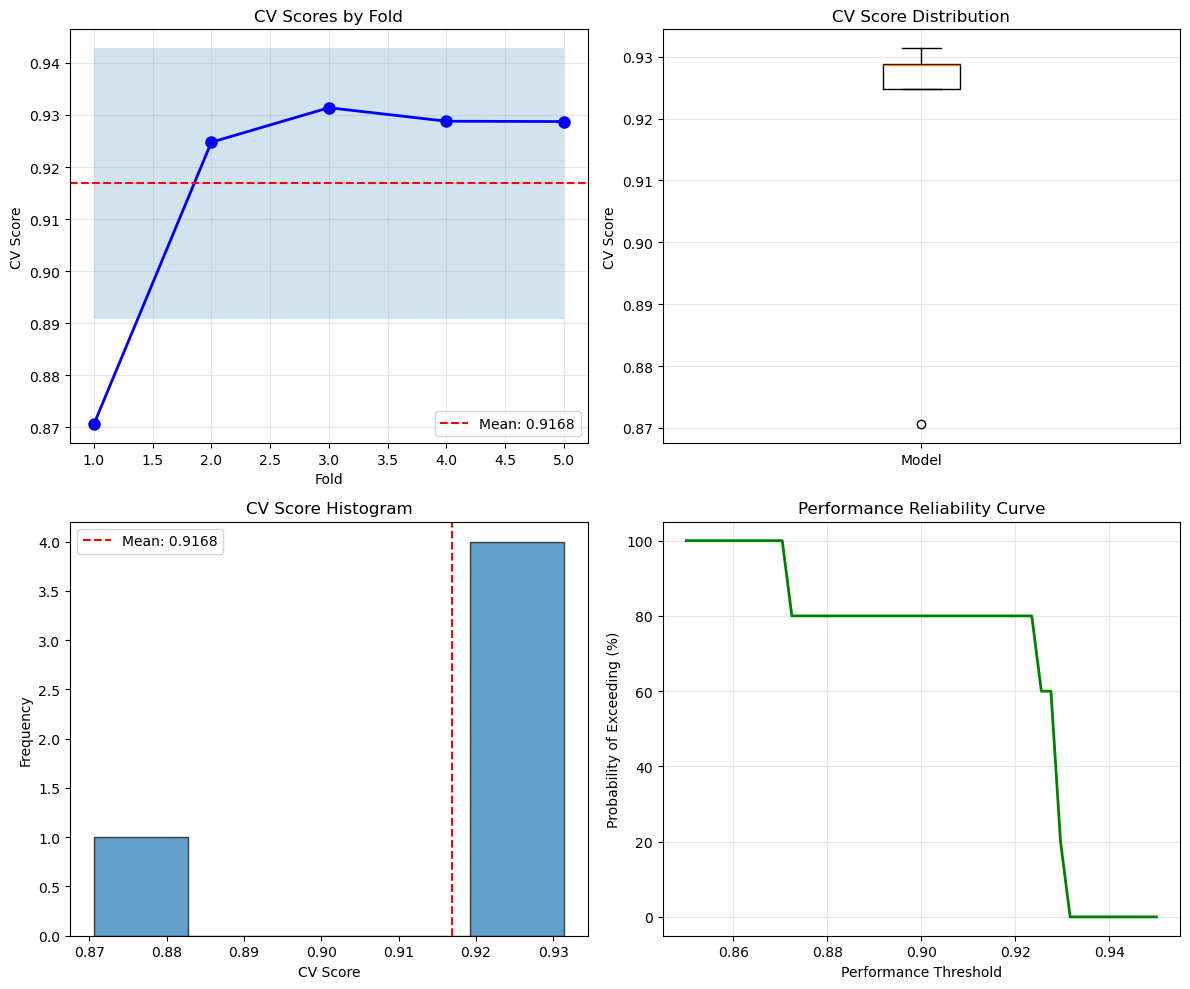

In [133]:
# 9. Visualization Code
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Individual fold scores
ax1.plot(range(1, 6), cv_scores, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
ax1.fill_between(range(1, 6), np.mean(cv_scores) - np.std(cv_scores, ddof=1), 
                 np.mean(cv_scores) + np.std(cv_scores, ddof=1), alpha=0.2)
ax1.set_xlabel('Fold')
ax1.set_ylabel('CV Score')
ax1.set_title('CV Scores by Fold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot
ax2.boxplot(cv_scores, labels=['Model'])
ax2.set_ylabel('CV Score')
ax2.set_title('CV Score Distribution')
ax2.grid(True, alpha=0.3)

# 3. Histogram
ax3.hist(cv_scores, bins=5, edgecolor='black', alpha=0.7)
ax3.axvline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
ax3.set_xlabel('CV Score')
ax3.set_ylabel('Frequency')
ax3.set_title('CV Score Histogram')
ax3.legend()

# 4. Performance reliability
thresholds = np.linspace(0.85, 0.95, 50)
probabilities = [np.mean(cv_scores >= t) * 100 for t in thresholds]
ax4.plot(thresholds, probabilities, 'g-', linewidth=2)
ax4.set_xlabel('Performance Threshold')
ax4.set_ylabel('Probability of Exceeding (%)')
ax4.set_title('Performance Reliability Curve')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== RIDGE vs GRADIENTBOOSTING COMPARISON ===

1. BASIC PERFORMANCE METRICS:
Metric                    Ridge        GradientBoosting Difference  
-----------------------------------------------------------------
Mean Score                0.916849     0.919772         +0.002922   
Std Deviation             0.025981     0.038278         +0.012297   
CV (%)                    2.83         4.16             +1.33       
Min Score                 0.870566     0.852377         -0.018189   
Max Score                 0.931392     0.943248         +0.011856   
Range                     0.060826     0.090870         +0.030045   

2. STATISTICAL SIGNIFICANCE TESTS:
H0: Ridge and GradientBoosting have equal performance
Paired t-test: t=0.5088, p-value=0.637696
Wilcoxon signed-rank test: W=5.0000, p-value=0.625000
Significant at α=0.05? No

3. EFFECT SIZE ANALYSIS:
Cohen's d: 0.0893 (small effect)
Relative improvement: +0.32%

4. FOLD-BY-FOLD ANALYSIS:
Fold   Ridge        GradBoost    Difference   Wi

/var/folders/tn/yy89yz_94q5b571nxcz7c_2m0000gn/T/ipykernel_1658/1454376442.py:142: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)


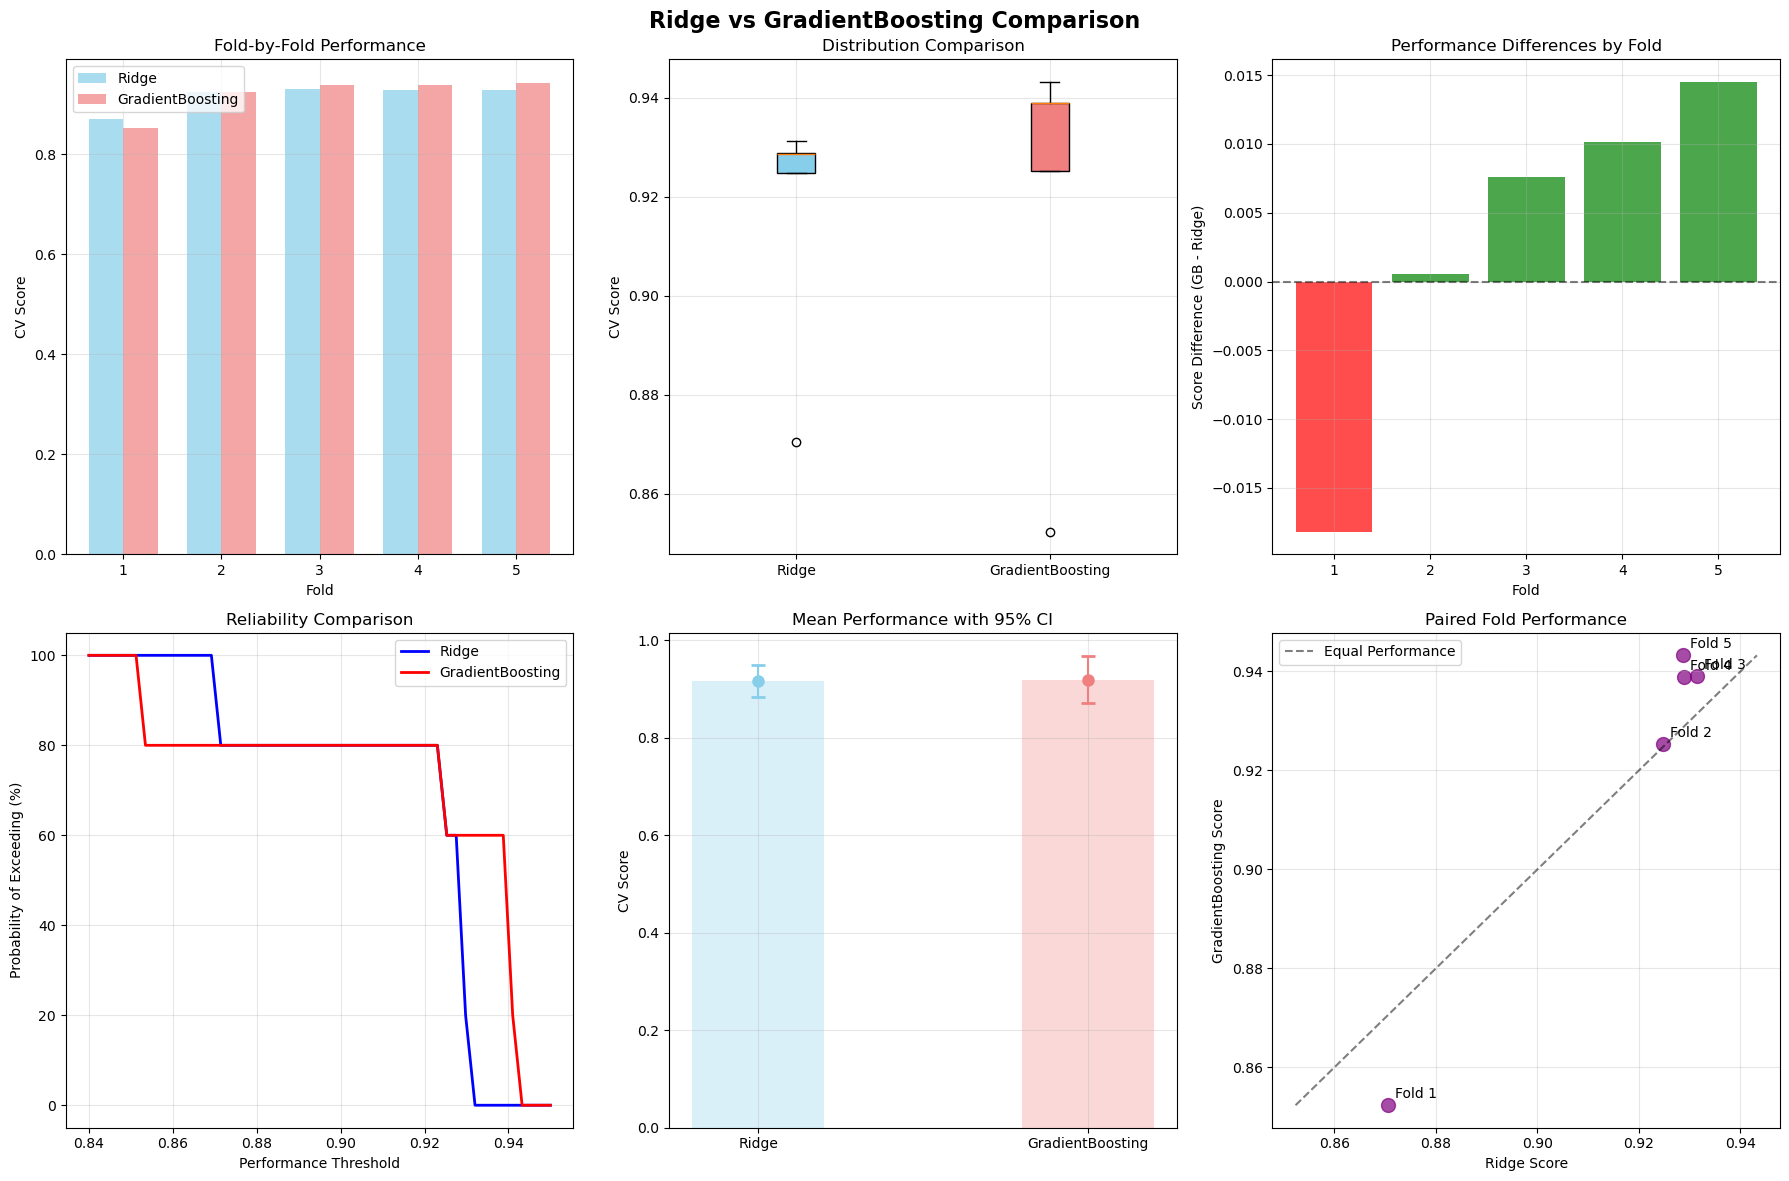

In [138]:
# Comparing to Gradient Boosting.
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_rel, wilcoxon
import seaborn as sns

# Model CV scores
r_scores = np.array([0.87056609, 0.92475999, 0.93139183, 0.92879547, 0.92873372])  # Ridge
g_scores = np.array([0.85237731, 0.92529127, 0.93901871, 0.93892317, 0.94324767])  # GradientBoosting (approximate from plot)

print("=== RIDGE vs GRADIENTBOOSTING COMPARISON ===\n")

# 1. BASIC PERFORMANCE COMPARISON
print("1. BASIC PERFORMANCE METRICS:")
print(f"{'Metric':<25} {'Ridge':<12} {'GradientBoosting':<16} {'Difference':<12}")
print("-" * 65)
print(f"{'Mean Score':<25} {np.mean(r_scores):<12.6f} {np.mean(g_scores):<16.6f} {np.mean(g_scores) - np.mean(r_scores):<+12.6f}")
print(f"{'Std Deviation':<25} {np.std(r_scores, ddof=1):<12.6f} {np.std(g_scores, ddof=1):<16.6f} {np.std(g_scores, ddof=1) - np.std(r_scores, ddof=1):<+12.6f}")
print(f"{'CV (%)':<25} {(np.std(r_scores, ddof=1)/np.mean(r_scores)*100):<12.2f} {(np.std(g_scores, ddof=1)/np.mean(g_scores)*100):<16.2f} {(np.std(g_scores, ddof=1)/np.mean(g_scores)*100) - (np.std(r_scores, ddof=1)/np.mean(r_scores)*100):<+12.2f}")
print(f"{'Min Score':<25} {np.min(r_scores):<12.6f} {np.min(g_scores):<16.6f} {np.min(g_scores) - np.min(r_scores):<+12.6f}")
print(f"{'Max Score':<25} {np.max(r_scores):<12.6f} {np.max(g_scores):<16.6f} {np.max(g_scores) - np.max(r_scores):<+12.6f}")
print(f"{'Range':<25} {np.max(r_scores) - np.min(r_scores):<12.6f} {np.max(g_scores) - np.min(g_scores):<16.6f} {(np.max(g_scores) - np.min(g_scores)) - (np.max(r_scores) - np.min(r_scores)):<+12.6f}")
print()

# 2. STATISTICAL SIGNIFICANCE TESTS
print("2. STATISTICAL SIGNIFICANCE TESTS:")
print("H0: Ridge and GradientBoosting have equal performance")

# Paired t-test
t_stat, t_pval = ttest_rel(g_scores, r_scores)
print(f"Paired t-test: t={t_stat:.4f}, p-value={t_pval:.6f}")

# Wilcoxon signed-rank test (non-parametric)
w_stat, w_pval = wilcoxon(g_scores, r_scores, alternative='two-sided')
print(f"Wilcoxon signed-rank test: W={w_stat:.4f}, p-value={w_pval:.6f}")

alpha = 0.05
print(f"Significant at α={alpha}? {'Yes' if min(t_pval, w_pval) < alpha else 'No'}")
print()

# 3. EFFECT SIZE
print("3. EFFECT SIZE ANALYSIS:")
# Cohen's d for paired samples
pooled_std = np.sqrt(((len(r_scores)-1)*np.std(r_scores, ddof=1)**2 + (len(g_scores)-1)*np.std(g_scores, ddof=1)**2) / (len(r_scores) + len(g_scores) - 2))
cohens_d = (np.mean(g_scores) - np.mean(r_scores)) / pooled_std
effect_size = "small" if abs(cohens_d) < 0.5 else "medium" if abs(cohens_d) < 0.8 else "large"
print(f"Cohen's d: {cohens_d:.4f} ({effect_size} effect)")

# Practical significance
perf_improvement = ((np.mean(g_scores) - np.mean(r_scores)) / np.mean(r_scores)) * 100
print(f"Relative improvement: {perf_improvement:+.2f}%")
print()

# 4. FOLD-BY-FOLD ANALYSIS
print("4. FOLD-BY-FOLD ANALYSIS:")
print(f"{'Fold':<6} {'Ridge':<12} {'GradBoost':<12} {'Difference':<12} {'Winner'}")
print("-" * 50)
wins_gb = 0
for i in range(len(r_scores)):
    diff = g_scores[i] - r_scores[i]
    winner = "GradBoost" if diff > 0 else "Ridge" if diff < 0 else "Tie"
    if diff > 0:
        wins_gb += 1
    print(f"{i+1:<6} {r_scores[i]:<12.6f} {g_scores[i]:<12.6f} {diff:<+12.6f} {winner}")

print(f"\nGradientBoosting wins: {wins_gb}/5 folds")
print()

# 5. RISK ANALYSIS COMPARISON
print("5. RISK ANALYSIS COMPARISON:")
threshold = 0.90

r_below = np.sum(r_scores < threshold)
g_below = np.sum(g_scores < threshold)
print(f"Scores below {threshold}:")
print(f"  Ridge: {r_below}/5 ({r_below/5*100:.1f}%)")
print(f"  GradientBoosting: {g_below}/5 ({g_below/5*100:.1f}%)")

# Value at Risk (worst case scenarios)
r_var5 = np.percentile(r_scores, 5)
g_var5 = np.percentile(g_scores, 5)
print(f"\n5% VaR (worst 5% performance):")
print(f"  Ridge: {r_var5:.6f}")
print(f"  GradientBoosting: {g_var5:.6f}")
print(f"  Improvement: {g_var5 - r_var5:+.6f}")
print()

# 6. CONFIDENCE INTERVALS
print("6. CONFIDENCE INTERVALS (95%):")
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    t_critical = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin = t_critical * sem
    return mean - margin, mean + margin

r_ci = confidence_interval(r_scores)
g_ci = confidence_interval(g_scores)

print(f"Ridge CI: [{r_ci[0]:.6f}, {r_ci[1]:.6f}]")
print(f"GradBoost CI: [{g_ci[0]:.6f}, {g_ci[1]:.6f}]")
overlap = not (r_ci[1] < g_ci[0] or g_ci[1] < r_ci[0])
print(f"Confidence intervals overlap: {'Yes' if overlap else 'No'}")
print()

# 7. STABILITY COMPARISON
print("7. STABILITY COMPARISON:")
r_stability = 1 - (np.std(r_scores, ddof=1) / np.mean(r_scores))
g_stability = 1 - (np.std(g_scores, ddof=1) / np.mean(g_scores))
print(f"Ridge Stability Index: {r_stability:.4f}")
print(f"GradientBoosting Stability Index: {g_stability:.4f}")
print(f"Stability improvement: {g_stability - r_stability:+.4f}")
print()

print("="*65)
print("VISUALIZATION CODE - Run separately:")

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Ridge vs GradientBoosting Comparison', fontsize=16, fontweight='bold')

# 1. Side-by-side fold performance
ax1 = axes[0, 0]
x = np.arange(1, 6)
width = 0.35
ax1.bar(x - width/2, r_scores, width, label='Ridge', alpha=0.7, color='skyblue')
ax1.bar(x + width/2, g_scores, width, label='GradientBoosting', alpha=0.7, color='lightcoral')
ax1.set_xlabel('Fold')
ax1.set_ylabel('CV Score')
ax1.set_title('Fold-by-Fold Performance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot comparison
ax2 = axes[0, 1]
box_data = [r_scores, g_scores]
box_labels = ['Ridge', 'GradientBoosting']
bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('skyblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.set_ylabel('CV Score')
ax2.set_title('Distribution Comparison')
ax2.grid(True, alpha=0.3)

# 3. Difference plot
ax3 = axes[0, 2]
differences = g_scores - r_scores
colors = ['green' if d > 0 else 'red' for d in differences]
ax3.bar(range(1, 6), differences, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_xlabel('Fold')
ax3.set_ylabel('Score Difference (GB - Ridge)')
ax3.set_title('Performance Differences by Fold')
ax3.grid(True, alpha=0.3)

# 4. Reliability curves
ax4 = axes[1, 0]
thresholds = np.linspace(0.84, 0.95, 50)
r_reliability = [np.mean(r_scores >= t) * 100 for t in thresholds]
g_reliability = [np.mean(g_scores >= t) * 100 for t in thresholds]
ax4.plot(thresholds, r_reliability, 'b-', linewidth=2, label='Ridge')
ax4.plot(thresholds, g_reliability, 'r-', linewidth=2, label='GradientBoosting')
ax4.set_xlabel('Performance Threshold')
ax4.set_ylabel('Probability of Exceeding (%)')
ax4.set_title('Reliability Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Mean and confidence intervals
ax5 = axes[1, 1]
models = ['Ridge', 'GradientBoosting']
means = [np.mean(r_scores), np.mean(g_scores)]
cis = [confidence_interval(r_scores), confidence_interval(g_scores)]
colors = ['skyblue', 'lightcoral']

for i, (model, mean, ci, color) in enumerate(zip(models, means, cis, colors)):
    ax5.errorbar(i, mean, yerr=[[mean - ci[0]], [ci[1] - mean]], 
                fmt='o', capsize=5, capthick=2, color=color, markersize=8)
    ax5.bar(i, mean, alpha=0.3, color=color, width=0.4)

ax5.set_xticks(range(len(models)))
ax5.set_xticklabels(models)
ax5.set_ylabel('CV Score')
ax5.set_title('Mean Performance with 95% CI')
ax5.grid(True, alpha=0.3)

# 6. Scatter plot of paired scores
ax6 = axes[1, 2]
ax6.scatter(r_scores, g_scores, s=100, alpha=0.7, color='purple')
for i, (x, y) in enumerate(zip(r_scores, g_scores)):
    ax6.annotate(f'Fold {i+1}', (x, y), xytext=(5, 5), textcoords='offset points')

# Add diagonal line (y=x)
min_val = min(min(r_scores), min(g_scores))
max_val = max(max(r_scores), max(g_scores))
ax6.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Equal Performance')
ax6.set_xlabel('Ridge Score')
ax6.set_ylabel('GradientBoosting Score')
ax6.set_title('Paired Fold Performance')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resources
[Return To Top](#Contents)

**Dean De Cock paper and original data:**

- [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](https://jse.amstat.org/v19n3/decock.pdf)

- [DataDocumentation.txt](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

- [Ames Data Dictionary on Github](https://github.com/Padre-Media/dataset/blob/main/Ames%20Data%20Dictionary.txt)

# Extra